In [3]:
import os, zipfile, shutil, glob, random, json, pathlib

from google.colab import files
print("Please upload your kaggle.json file...")
uploaded = files.upload()

os.makedirs("/root/.kaggle", exist_ok=True)
for fname in uploaded:
    shutil.move(fname, f"/root/.kaggle/{fname}")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!pip -q install kaggle --upgrade
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types -p /content/data

os.makedirs("/content/data", exist_ok=True)
zip_path = glob.glob("/content/data/*.zip")[0]
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/data")
print("Extraction completed successfully.")

Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
100% 2.02G/2.02G [00:19<00:00, 128MB/s]
100% 2.02G/2.02G [00:19<00:00, 113MB/s]
Extraction completed successfully.


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [14]:
import os
directory = "/content/data/Lung Disease Dataset/train"

def explore_directory(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return
    print(f"Exploring contents of: {directory}\n")
    num_dirs = 0
    num_files = 0
    dir_details = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            num_dirs += 1
            num_files_in_dir = len([f for f in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, f))])
            dir_details.append((item, num_files_in_dir))
        elif os.path.isfile(item_path):
            num_files += 1
    print(f"Summary:\n- Total directories: {num_dirs}\n- Total files: {num_files}\n")
    if dir_details:
        print("Directory details:")
        for dir_name, file_count in dir_details:
            print(f"  - {dir_name}: {file_count} files")
    else:
        print("No subdirectories found.")

    root_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if root_files:
        print("\nFiles in the root directory:")
        for file in root_files:
            print(f"  - {file}")

explore_directory(directory)

Exploring contents of: /content/data/Lung Disease Dataset/train

Summary:
- Total directories: 5
- Total files: 0

Directory details:
  - Tuberculosis: 1220 files
  - Bacterial Pneumonia: 1205 files
  - Corona Virus Disease: 1218 files
  - Viral Pneumonia: 1204 files
  - Normal: 1207 files


Error loading image: /content/data/Lung Disease Dataset/train/Tuberculosis/test_0_2328.jpeg
Error loading image: /content/data/Lung Disease Dataset/train/Bacterial Pneumonia/553.jpeg
Error loading image: /content/data/Lung Disease Dataset/train/Corona Virus Disease/00030652_004.png
Error loading image: /content/data/Lung Disease Dataset/train/Viral Pneumonia/VIRUS-9162717-0001.jpeg
Error loading image: /content/data/Lung Disease Dataset/train/Normal/IM-0613-0001.jpeg


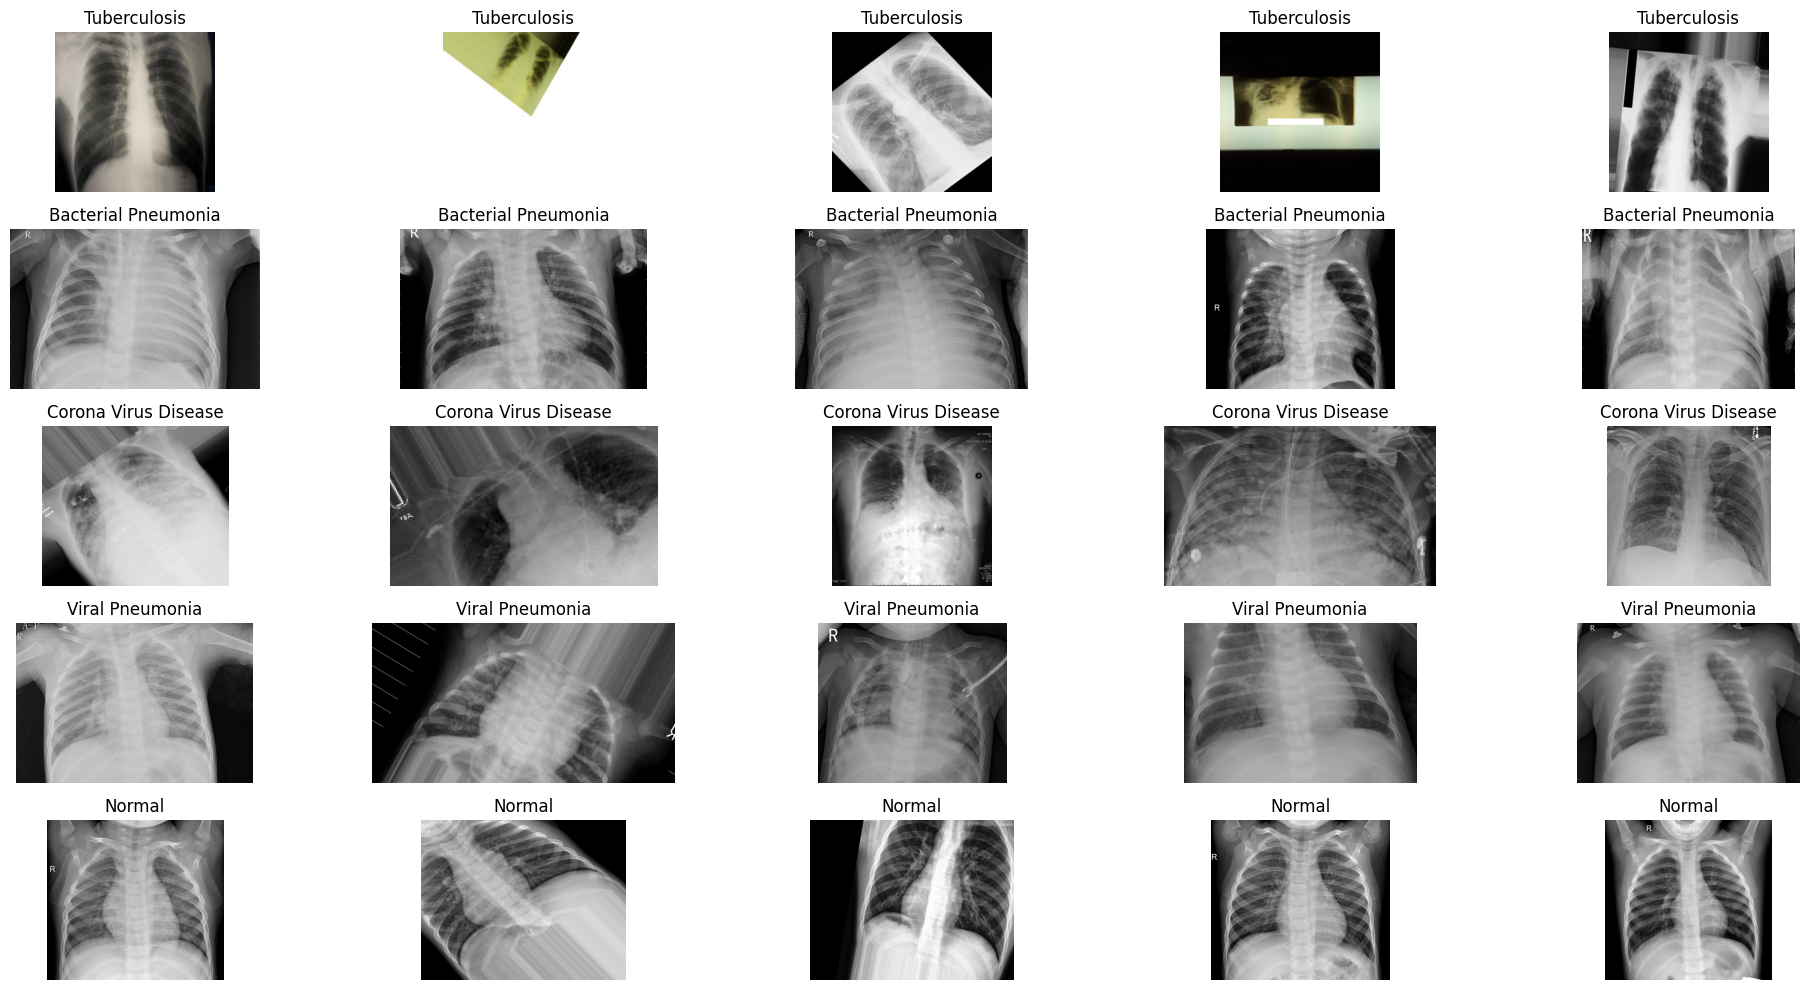

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

image_dir = "/content/data/Lung Disease Dataset/train"
classes = os.listdir(image_dir)
num_classes = len(classes)
images_per_class = 5
plt.figure(figsize=(20, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(image_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))][:images_per_class]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path)
        if img is not None:
          plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
          plt.imshow(img)
          plt.title(f"{class_name}")
          plt.axis('off')
    else:
          print(f"Error loading image: {image_path}")

plt.tight_layout()
plt.show()

In [16]:
image_size = (240, 240)
batch_size = 16
num_epochs = 150
image_input = Input(shape=(240, 240, 3))

In [17]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xcp_pre
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

xception_model = Xception(weights='imagenet',
                          include_top=False,
                          input_tensor=image_input)

x = xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=image_input, outputs=output)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications.densenet import preprocess_input
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_dataset = train_datagen.flow_from_directory(
    '/content/data/Lung Disease Dataset/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


val_dataset = val_datagen.flow_from_directory(
    '/content/data/Lung Disease Dataset/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[lr_scheduler, early_stopping]
)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Epoch 1/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 255s 537ms/step - accuracy: 0.6745 - loss: 0.8459 - val_accuracy: 0.7307 - val_loss: 0.7655 - learning_rate: 0.0010
Epoch 2/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 177s 465ms/step - accuracy: 0.7983 - loss: 0.5430 - val_accuracy: 0.6468 - val_loss: 1.3789 - learning_rate: 0.0010
Epoch 3/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 177s 467ms/step - accuracy: 0.8104 - loss: 0.4842 - val_accuracy: 0.6190 - val_loss: 1.7854 - learning_rate: 0.0010
Epoch 4/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 176s 463ms/step - accuracy: 0.8470 - loss: 0.3932 - val_accuracy: 0.7371 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 5/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 176s 464ms/step - accuracy: 0.8546 - loss: 0.3751 - val_accuracy: 0.8571 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 6/150
379/379 ━━━━━━━━━━━━━━━━━━━━ 176s 464ms/step - accuracy: 0.8554 - loss: 0.3728 - val_accuracy: 0.8661 - val_loss: 0.361

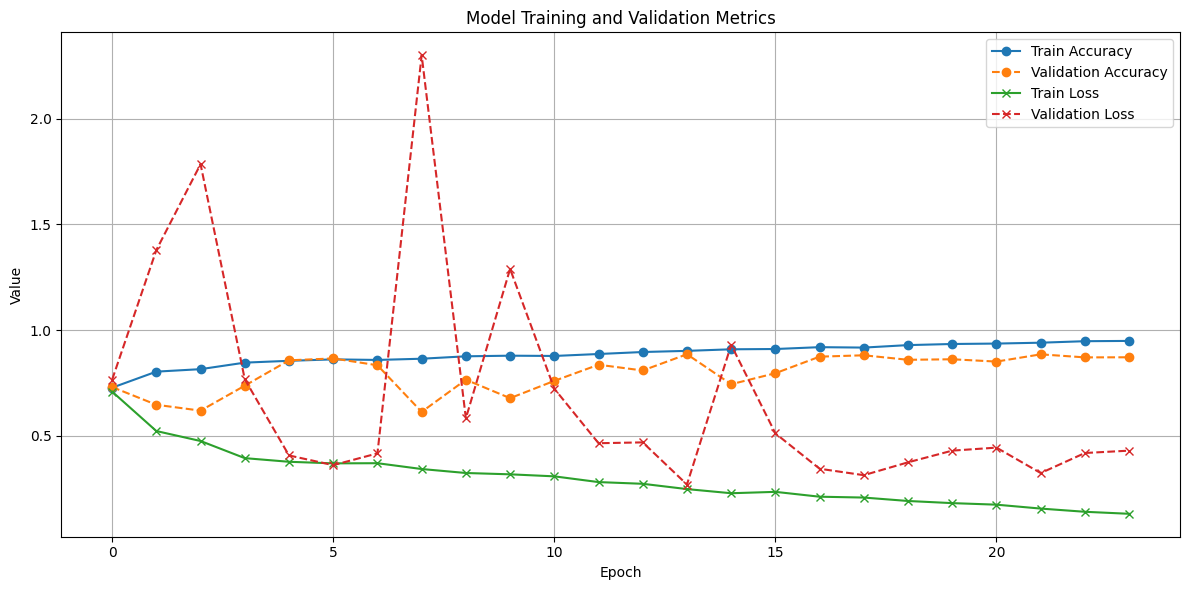

In [19]:
import matplotlib.pyplot as plt

def plot_combined_history(history):
    plt.figure(figsize=(12, 6))

    plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='o')
    plt.plot(history.history['loss'], label='Train Loss', linestyle='-', marker='x')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='x')

    plt.title('Model Training and Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_history(history)

In [24]:
atest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_dataset = test_datagen.flow_from_directory(
    '/content/data/Lung Disease Dataset/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2025 images belonging to 5 classes.


In [25]:
start_time = time.time()
evaluation_result = model.evaluate(test_dataset)
print("Time taken to evaluate the model: " + str(time.time() - start_time))

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

y_pred = model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)

true_labels = test_dataset.labels

print(classification_report(true_labels, y_pred_bool, digits=4))

np.savetxt("y_true.txt", true_labels, fmt="%d")
np.savetxt("y_pred.txt", y_pred_bool, fmt="%d")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8628 - loss: 0.3107
Time taken to evaluate the model: 41.03843879699707
Test Loss: 0.264118492603302
Test Accuracy: 0.8953086137771606
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step
              precision    recall  f1-score   support

           0     0.8481    0.7345    0.7872       403
           1     0.9782    0.9926    0.9854       407
           2     0.8944    0.9851    0.9376       404
           3     0.9975    0.9926    0.9951       408
           4     0.7524    0.7692    0.7607       403

    accuracy                         0.8953      2025
   macro avg     0.8941    0.8948    0.8932      2025
weighted avg     0.8946    0.8953    0.8937      2025



127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step
Overall Accuracy: 89.53%


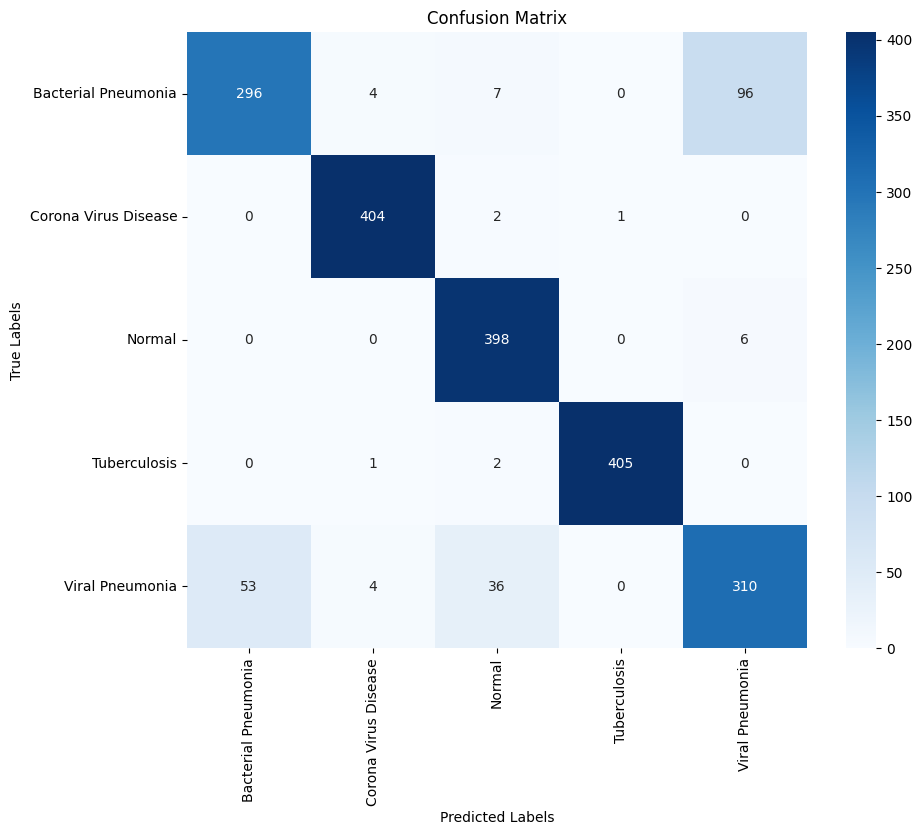

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = test_dataset.classes

conf_matrix = confusion_matrix(rounded_labels, y_pred_bool)
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f'Overall Accuracy: {accuracy*100:.2f}%')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()